# Krusell Smith

### KS

In the benchmark Krusell-Smith model, heterogeneity stems from the assumption that idiosyncratic income shocks are partially uninsurable. Each agent faces two types of uncertainty, (i) whether the agent is employed or not (which is idiosyncratic), and (ii) the aggregate state of the economy. There is only one type of consumer, which is infinitely lived. Where possible, we follow the notation of Krusell and Smith (1998).

Preferences of the agents are CRRA. Each agent is endowed with one unit of time, and supplies $l\epsilon$ units of labour in a given period. $\epsilon$ is stochartic and is either zero or one and denotes whether the agent is employed or unemployed. The agent can save and self insure by buying capital $k$ which is bounded below at the borrowing constraint of 0.

There is production of only one good, output ($y$), which follows a Cobb-Douglas production funcation using capital and labour. Variables with bars above denote aggregate variables: $y = z\bar{k}^\alpha \bar{l}^{1-\alpha}$. $z$ denotes the aggregate shock to productivity. $z$ can take two values, either $z_g$ which denotes a "good" state, or $z_b$ which denotes a "bad" state. Consumers gain income from the rental return on capital and labour, both of which are paid their marginal products.

The aggregate shocks follow first-order Markov chains, with the transition probability of moving from state $s$ to state $s'$ denoted by $\pi_{ss'}$. The aggregate shocks and individual shocks are correlated. We assume that the individual shocks satisfy the law of large numbers, such that the number of agents who are unemployed in the good state always equals $u_g$ and $u_b$ in the bad state. For the individual, the probability of moving between a good state and employment to a bad state and unemployment is denoted $\pi_{gb10}$ with similar notations for the other transition probabilities.

Finally, denote $\Gamma$ as the current distribution of consumers over capital and employment status, and let $H$ be the law of motion of this distribution. 

The individual's problem is:
\begin{eqnarray*}
V(k, \epsilon; \Gamma, z) &=& max_{c, k'}\{U(c) + \beta E[V(k' ,\epsilon'; \Gamma', z')|z, \epsilon]\} \\
c + k' &=& r(\bar{k}, \bar{l}, z)k + w(\bar{k}, \bar{l}, z)l\epsilon + (1-\delta)k \\
\Gamma' &=& H(\Gamma, z, z') \\
k' &\geq& 0 \\
\end{eqnarray*}

Krusell and Smith then define a recursive competitive equilibrium as a law of motion $H$, a value function $V$, decision rule for updating capital $f$ and pricing functions $r$ and $w$, such that $V$ and $f$ solve the consumers problem, $r$ and $w$ denote the marginal productionns of capital and labour, and $H$ is consistent with $f$ (i.e. if we add up all of the individual agents capital choices we get the correct distribution of capital).

#### The Consumer

In [1]:
# Initial imports and notebook setup

%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
from copy import copy
from HARK.utilities import plotFuncs, plotFuncsDer
from HARK.ConsumptionSaving.ConsAggShockModel import *
import HARK.ConsumptionSaving.ConsumerParameters as Params

In [2]:
# Import Markov consumer type that allows aggregate shocks too

from HARK.ConsumptionSaving.ConsAggShockModel import AggShockMarkovConsumerType

In [3]:
# This cell defines a dictionary to make an instance of our Krusell-Smith consumer.
KSAgentDictionary = { 
    "CRRA": 1.0,                           # Coefficient of relative risk aversion
    "DiscFac": 0.99,                       # Intertemporal discount factor
    "LivPrb" : [1.0],                      # Survival probability
    "AgentCount" : 10000,                  # Number of agents of this type (only matters for simulation)
    "aNrmInitMean" : 0.0,                  # Mean of log initial assets (only matters for simulation)
    "aNrmInitStd"  : 0.0,                  # Standard deviation of log initial assets (only for simulation)
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
# Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value               
    "aXtraExtra" : [None],                 # Some other value of "assets above minimum" to add to the grid
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraCount" : 24,                     # Number of points in the grid of "assets above minimum"
# Parameters describing the income process
    "PermShkCount" : 1,                    # Number of points in discrete approximation to permanent income shocks - no shocks!
    "TranShkCount" : 1,                    # Number of points in discrete approximation to transitory income shocks - no shocks!
    "PermShkStd" : [0.],                   # Standard deviation of log permanent income shocks - no shocks!
    "TranShkStd" : [0.],                   # Standard deviation of log transitory income shocks - no shocks!
    "UnempPrb" : 0.0,                      # Probability of unemployment while working - no shocks!
    "UnempPrbRet" : 0.00,                  # Probability of "unemployment" while retired - no shocks!
    "IncUnemp" : 0.0,                      # Unemployment benefits replacement rate
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "tax_rate" : 0.0,                      # Flat income tax rate
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets   
    "cycles": 0,                           # Consumer is infinitely lived
    "PermGroFac" : [1.0],                  # Permanent income growth factor
# New Parameters that we need now    
    'MgridBase': np.array([0.1,0.3,0.6,
                           0.8,0.9,0.98,
                           1.0,1.02,1.1,
                           1.2,1.6,2.0,
                           3.0]),          # Grid of capital-to-labor-ratios (factors)
    'MrkvArray': np.array([[0.90,0.10],
                           [0.04,0.96]]),  # Transition probabilities for macroecon. [i,j] is probability of being in state j next
                                           # period conditional on being in state i this period. 
    'PermShkAggStd' : [0.0,0.0],           # Standard deviation of log aggregate permanent shocks by state. No continous shocks in a state.
    'TranShkAggStd' : [0.0,0.0],           # Standard deviation of log aggregate transitory shocks by state. No continuous shocks in a state.
    'PermGroFacAgg' : 1.0
}
# Markov array would be different no? These are transition probabilities for unemployment to employment? Not for aggregate econ?

In [4]:
KSAgent = AggShockMarkovConsumerType(**KSAgentDictionary)

In [5]:
KSAgent.IncomeDstn[0] = [[np.array([0.96,0.04]),np.array([1.0,1.0]),np.array([1.0/0.96,0.0])],
                                      [np.array([0.90,0.10]),np.array([1.0,1.0]),np.array([1.0/0.90,0.0])]]
# A list of lists, one for each aggregate Markov state, each containing five arrays of floats, representing a discrete 
# approximation to the income process. Order: event probabilities, idiosyncratic permanent shocks, idiosyncratic transitory
# shocks, aggregate permanent shocks, aggregate transitory shocks.

#### The Economy

In [6]:
from HARK.ConsumptionSaving.ConsAggShockModel import CobbDouglasMarkovEconomy

KSEconomyDictionary = {
    'PermShkAggCount': 1, 
    'TranShkAggCount': 1, 
    'PermShkAggStd': [0.0,0.0], 
    'TranShkAggStd': [0.0,0.0], 
    'DeprFac': 0.025, # Depreciation factor
    'CapShare': 0.36, # Share of capital income in cobb-douglas production function
    'DiscFac': 0.99,
    'CRRA': 1.0,
    'PermGroFacAgg': [1.0,1.0],
    'AggregateL':1.0, # Not sure on this. Looks like we have fixed the labour level...
    'act_T':1200, # Number of periods for economy to run in simulation
    'intercept_prev': [0.0,0.0], # Make some initial guesses at linear savings rule intercepts for each state
    'slope_prev': [1.0,1.0], # Make some initial guesses at linear savings rule slopes for each state
    'MrkvArray': np.array([[0.90,0.10],
                           [0.04,0.96]]), # Transition probabilities, again not sure these are correct
    'MrkvNow_init': 0   # Pick a state to start in (we pick the first state)
}

KSEconomy = CobbDouglasMarkovEconomy(agents = [KSAgent], **KSEconomyDictionary) # Combine production and consumption sides into an "Economy"

In [7]:
KSEconomy.AggShkDstn = [[np.array([1.0]),np.array([1.0]),np.array([1.01])],
                                 [np.array([1.0]),np.array([1.0]),np.array([0.99])]]

# Aggregate productivity shock distribution.  First element is probalities, given the state you are in.
# Second element is agg permanent shocks (here we don't have any, so just they are just 1.).
# Third element is agg transitory shocks, which are calibrated the same as in Krusell Smith.

In [8]:
# Solve macro problem by getting a fixed point dynamic rule

KSAgent.getEconomyData(KSEconomy) # Makes attributes of the economy, attributes of the agent
KSEconomy.makeAggShkHist() # Make a simulated history of the economy
KSEconomy.solve() # Solve the economy using the market method. i.e. guess the saving function, and iterate until a fixed point

intercept=[-0.38054409330505196, -0.375256383341549], slope=[1.0933771979871654, 1.092432077552559], r-sq=[0.999686355927023, 0.9996236083586674]
intercept=[-0.11956996353520935, -0.11646961362754524], slope=[1.002458047269589, 1.0015275167710984], r-sq=[0.9999982177651398, 0.9999953676602366]
intercept=[-0.06554436963697159, -0.06490715561578525], slope=[1.0056342072668347, 1.005452524112099], r-sq=[0.9999999998185232, 0.9999999998420872]
intercept=[-0.34675500119858405, -0.35870297782002863], slope=[1.0786702185692845, 1.0831003194377324], r-sq=[0.9999689096693677, 0.9999662045891838]
intercept=[-0.09053421909365576, -0.08833612654247389], slope=[0.9983511587005094, 0.9976478956059956], r-sq=[0.9999999248104373, 0.9999998678149605]
intercept=[-0.07487186647219288, -0.07442491102741286], slope=[1.0074799925699218, 1.0073468689906528], r-sq=[0.9999999994955238, 0.9999999995594158]
intercept=[-0.34335404021934496, -0.3566826996069741], slope=[1.077325789083436, 1.0821334836997445], r-sq

Aggregate savings as a function of aggregate market resources:


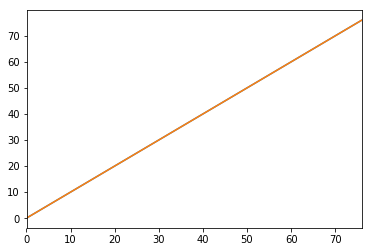

Wage rate as function of capital ratio:


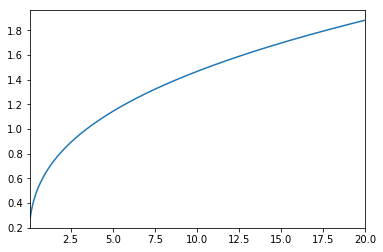

Interest factor as function of capital ratio


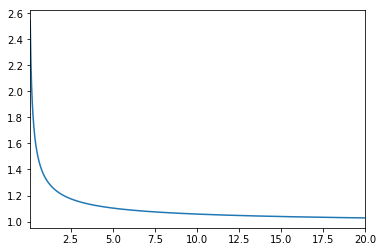

Consumption function at each aggregate market resources gridpoint (in general equilibrium):


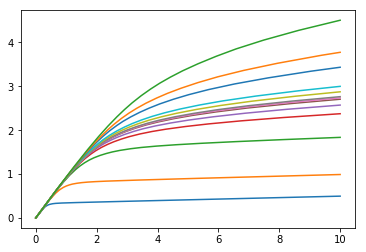

Consumption function at each aggregate market resources gridpoint (in general equilibrium):


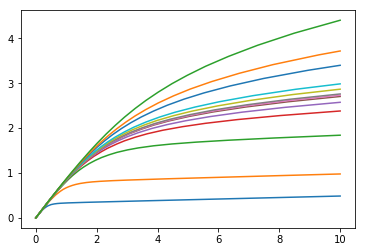

In [18]:
# Lets plot our results

print('Aggregate savings as a function of aggregate market resources:')
plotFuncs(KSEconomy.AFunc,0.1,2*KSEconomy.kSS)

print('Wage rate as function of capital ratio:')
plotFuncs(KSEconomy.wFunc, 0.1, 20) 

print('Interest factor as function of capital ratio')
plotFuncs(KSEconomy.Rfunc, 0.1, 20)

print('Consumption function at each aggregate market resources gridpoint (in general equilibrium):')
KSAgent.unpackcFunc()
m_grid = np.linspace(0,10,200)
KSAgent.unpackcFunc()
for M in KSAgent.Mgrid:
    c_at_this_M = KSAgent.solution[0].cFunc[0](m_grid,M*np.ones_like(m_grid)) #Have two consumption functions, check this
    plt.plot(m_grid,c_at_this_M)
plt.show()

print('Consumption function at each aggregate market resources gridpoint (in general equilibrium):')
KSAgent.unpackcFunc()
m_grid = np.linspace(0,10,200)
KSAgent.unpackcFunc()
for M in KSAgent.Mgrid:
    c_at_this_M = KSAgent.solution[0].cFunc[1](m_grid,M*np.ones_like(m_grid)) #Have two consumption functions, check this
    plt.plot(m_grid,c_at_this_M)
plt.show()

In [17]:
dir(KSAgent.solution[0].cFunc[0])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_derX',
 '_derY',
 '_evaluate',
 'assignParameters',
 'derivativeX',
 'derivativeY',
 'distance',
 'distance_criteria',
 'funcCount',
 'functions',
 'getAvg']

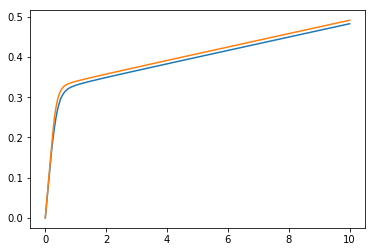

In [19]:
c0_at_this_M = KSAgent.solution[0].cFunc[1](m_grid,4.*np.ones_like(m_grid))
c1_at_this_M = KSAgent.solution[0].cFunc[0](m_grid,4.*np.ones_like(m_grid))

plt.plot(m_grid, c0_at_this_M)
plt.plot(m_grid, c1_at_this_M)
plt.show()

# Small difference, but that's OK because that's also what KS get in the good versus bad states.